<a href="https://colab.research.google.com/github/abhigoogol/Style-Transfer/blob/master/Style_Transfer_Gatys_CVPR2016.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print("GPU: ", torch.cuda.is_available())


!pip install Pillow==4.0.0
!pip install image

tcmalloc: large alloc 1073750016 bytes == 0x5cc16000 @  0x7fac91fc22a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
0.4.0
GPU:  True
    100% |████████████████████████████████| 5.6MB 1.1MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0
    100% |████████████████████████████████| 7.3MB 5.0MB/s 


In [3]:
from google.colab import files
files.upload()
!ls

Saving wave.jpg to wave.jpg
sample_data  turtle.jpg  wave.jpg


In [0]:
import torch
import torchvision.models as models
from torchvision import transforms
import torch.optim as optim

from PIL import Image

import matplotlib.pyplot as plt

In [5]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
  param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:15<00:00, 37962393.26it/s]


In [6]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
vgg.to(device)

cuda


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [0]:
def load_image(image_path, max_size=400, shape=None):
  image = Image.open(image_path).convert('RGB')
  
  if max(image.size) > max_size:
    size = max_size
  else:
    size = max(image.size)
    
  if shape is not None:
    size = shape
    
  im_transform = transforms.Compose([transforms.Resize(size), 
                                   transforms.ToTensor(), 
                                   transforms.Normalize(std=(0.229, 0.224, 0.225), mean=(0.485, 0.456, 0.406))])
  
  image = im_transform(image).unsqueeze(0)
  
  return image

In [9]:
content = load_image('turtle.jpg').to(device)
style = load_image('wave.jpg', shape=content.shape[-2:]).to(device)

print(content.shape)
print(style.shape)

torch.Size([1, 3, 400, 533])
torch.Size([1, 3, 400, 533])


In [0]:
def convert_back(tensor, std=(0.229, 0.224, 0.225), mean=(0.485, 0.456, 0.406)):
  image = tensor.to('cpu').clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1, 2, 0)
  image = image * std + mean
  image = image.clip(0, 1)
  
  return image

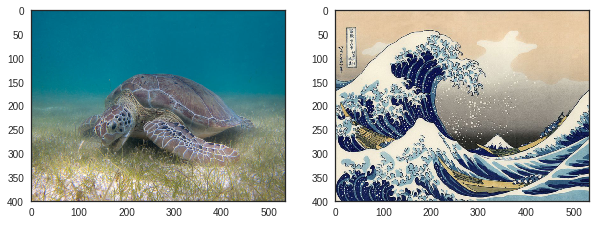

In [11]:
plt.style.use('seaborn-white')
# plt.style.use('classic')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(convert_back(content))
ax2.imshow(convert_back(style))

In [0]:
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
    features = {}
    x = image

    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [0]:
def gram_matrix(tensor):
  _, d, h, w = tensor.shape
  tensor = tensor.view(d, h*w)
  gram = torch.mm(tensor, tensor.t())
  
  return gram

In [0]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

style_grams = {layer:gram_matrix(style_features[layer]) for layer in style_features}

target = content.clone().requires_grad_(True).to(device)

In [15]:
style_grams.keys()

dict_keys(['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv4_2', 'conv5_1'])

In [0]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta

Total loss:  93791368.0


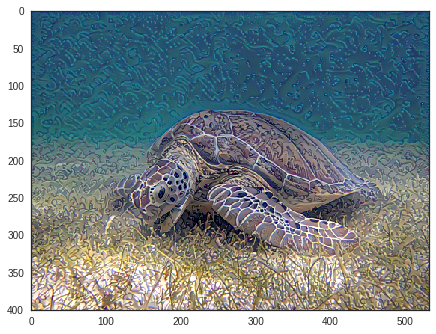

Total loss:  31533214.0


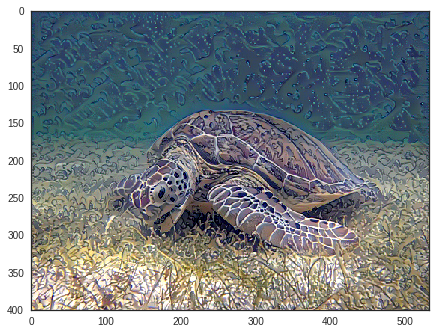

Total loss:  19020680.0


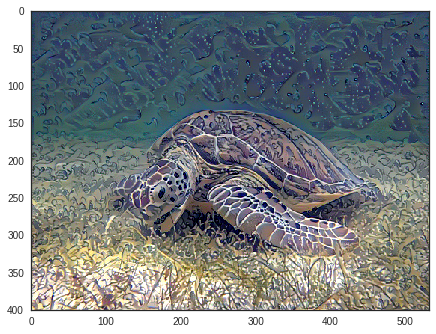

Total loss:  13838138.0


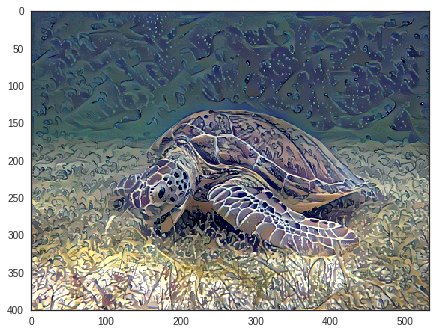

Total loss:  10960102.0


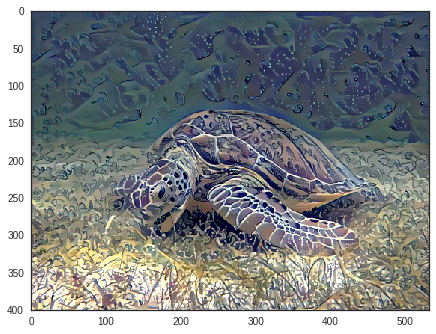

In [17]:
show = 400
optimizer = optim.Adam([target], lr=0.003)
steps = 2000

for s in range(1, steps+1):
  target_features = get_features(target, vgg)
  
  content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)
  
  style_loss = 0
  for each_layer in style_weights:
    target_feature = target_features[each_layer]
    gram_target = gram_matrix(target_feature)
    
    _, d, h, w = target_feature.shape
    
    style_gram = style_grams[each_layer]
    
    layer_style_loss = style_weights[each_layer] * torch.mean((gram_target - style_gram) ** 2)
    
    style_loss += layer_style_loss / (d * h * w)
    
  total_loss = content_weight * content_loss + style_weight * style_loss
  
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()
  
  if s % show == 0:
    print('Total loss: ', total_loss.item())
    plt.imshow(convert_back(target))
    plt.show()

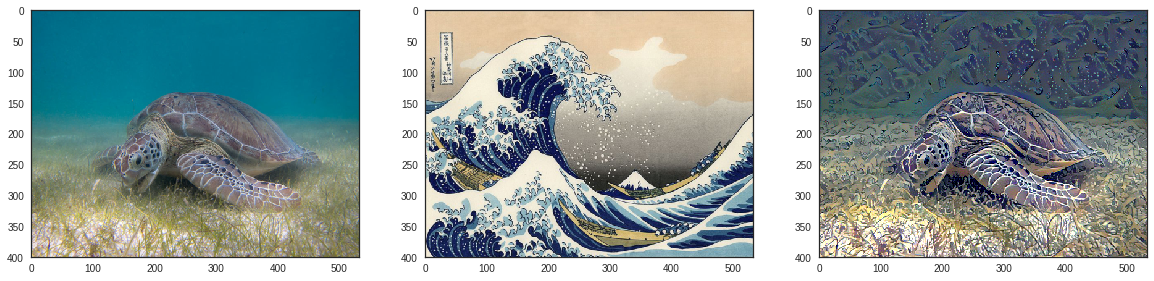

In [18]:
# display content and final, target image
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(convert_back(content))
ax2.imshow(convert_back(style))
ax3.imshow(convert_back(target))
